In [7]:
import pandas as pd 
import numpy as np 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from nltk.corpus import wordnet
import re

In [8]:
df_ss = pd.read_csv("sample_submission.csv")

In [9]:
df_train = pd.read_csv("train.csv")

In [10]:
df_test = pd.read_csv("test.csv")

In [11]:
df_train.head()

,example_id,text,label
0,140d03eabb7cb5c2558605eb8336689c,brandpost best of both worlds hybrid onsite an...,0
1,f7f1f906c9e2b76e63020f8794516185,$mention$ they shall in all cases except treas...,0
2,39f0b2ebc12e008a7a43ec318d0c3874,lifelock offers to protect you from the equifa...,0
3,ad4e57c69f00548253cb6d47b15c3ce4,skimmer adware spent two months in google play...,1
4,236bfe8f2f145dbcf17be122546946db,just want to love and be loved,0


In [12]:
df_train.shape

(1189, 3)

In [13]:
df_test.head()

,example_id,text
0,24bf52cc84b75bce8ee9c0cdd0b5117f,phishing heads to the cloud forbes $url$ cloud
1,708cc462eca0c274bcff304bbc4396f8,Sports Direct Failed to Tell Staff of Data Bre...
2,c5da1d371af9525d2fc2174311e3dae4,understanding vulnerability through humanright...
3,844f5f5be464a0600891ac6b8c1a1afd,cussword manager onelogin hit by data breach $...
4,97daba48c36db68f3e84ebcbf8952aa2,vuln multiple flexense products cve20177310 bu...


In [14]:
df_test.shape

(786, 2)

In [15]:
df_ss.head()

,example_id,label
0,24bf52cc84b75bce8ee9c0cdd0b5117f,False
1,708cc462eca0c274bcff304bbc4396f8,False
2,c5da1d371af9525d2fc2174311e3dae4,False
3,844f5f5be464a0600891ac6b8c1a1afd,False
4,97daba48c36db68f3e84ebcbf8952aa2,True


In [16]:
df_ss.shape

(786, 2)

In [17]:
df_outer = df_test.merge(df_ss, how = 'outer')

In [18]:
df_outer.head()

,example_id,text,label
0,24bf52cc84b75bce8ee9c0cdd0b5117f,phishing heads to the cloud forbes $url$ cloud,False
1,708cc462eca0c274bcff304bbc4396f8,Sports Direct Failed to Tell Staff of Data Bre...,False
2,c5da1d371af9525d2fc2174311e3dae4,understanding vulnerability through humanright...,False
3,844f5f5be464a0600891ac6b8c1a1afd,cussword manager onelogin hit by data breach $...,False
4,97daba48c36db68f3e84ebcbf8952aa2,vuln multiple flexense products cve20177310 bu...,True


In [19]:
df_outer.shape

(786, 3)

In [20]:
df_all = df_train.merge(df_outer, how = 'outer')# для создания общего словаря объединяем data frames
df_all.shape# 9 совпадающих сообщений в train test

(1966, 3)

In [21]:
#functons
stop_words=set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
def clean_tokens(tokens):
    ans = []
    for token in tokens:
        x = re.findall(r'[a-z]+.*[a-z]+', token)
        if len(x) != 0:
            ans.append(x[0])
    return ans
def delstopwords(lst, stop_words):
    filtered_sentence = [w for w in lst if not w in stop_words] 
    return filtered_sentence
def flat_nested(nested):
    flatten = []
    for item in nested:
        if isinstance(item, list):
            flatten.extend(item)
        else:
            flatten.append(item)
    return flatten
def create_cleaned(df, stop_words):
    l_split = df['text'].str.lower().str.split(r'[\n ]+').tolist()
    cleaned = [clean_tokens(tokens) for tokens in l_split]
    data_lemmatized = [[lemmatizer.lemmatize(token, wordnet.VERB) for token in tokens] for tokens in cleaned]
    del_swords = [delstopwords(tokens, stop_words) for tokens in data_lemmatized]
    return del_swords
def creat_vec(text):
    vec = np.zeros(len(cleaned_vocab))
    for token in text: 
        try: 
            vec += vocabulary[token]
        except KeyError:
            continue
    return vec

In [22]:
lst_train = create_cleaned(df_train, stop_words)
lst_all = create_cleaned(df_all, stop_words)
lst_test = create_cleaned(df_outer, stop_words)

In [23]:
from collections import Counter, defaultdict 

cnt_vocab = Counter(flat_nested(lst_all))
len(cnt_vocab)

5156

In [24]:
cnt_vocab.most_common(10)

[('url', 1482),
 ('breach', 701),
 ('malware', 565),
 ('mention', 360),
 ('vulnerability', 326),
 ('security', 233),
 ('phishing', 215),
 ('data', 210),
 ('attack', 163),
 ('equifax', 148)]

In [25]:
#cоздаем словарь и векторизируем слова

threshold_count = 3
threshold_len = 3
cleaned_vocab = [token for token, count in cnt_vocab.items() if count > threshold_count and len(token) > threshold_len]
print(len(cleaned_vocab))

vocabulary = defaultdict()
for i, token in enumerate(cleaned_vocab): 
    empty_vec = np.zeros(len(cleaned_vocab))
    empty_vec[i] = 1 
    vocabulary[token] = empty_vec
print(len(vocabulary['breach']))

818
818


In [26]:
#векторизируем текст train
import sklearn
v_train = np.array([creat_vec(list_tokens) for list_tokens in lst_train])
# используем np.array а не csr_matrix потому что выборка не велика
print('Train.shape: ', v_train.shape)


#векторизируем текст test
v_test = np.array([creat_vec(list_tokens) for list_tokens in lst_test])
print('Test.shape: ', v_test.shape)

Train.shape:  (1189, 818)
Test.shape:  (786, 818)


In [27]:
values_train = np.array([value for value in df_train['label']]).astype('float')
values_test = np.array([value for value in df_outer['label']]).astype('float')
print('Train')
for i in range (10): print(values_train[i])
print('\nTest')
for i in range (10): print(values_test[i])

Train
0.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0

Test
0.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0


# Random forest classifire

In [28]:
X_train, X_test, y_train, y_test = v_train, v_test, values_train, values_test
print(type(X_train))
print(type(y_test))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1189, 818) (1189,)
(786, 818) (786,)


In [211]:
# Попытка создать модель на имеющейся выборке и тут же ее порверить
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
y_pred = y_test
lab_enc = preprocessing.LabelEncoder()
clf = RandomForestClassifier(n_estimators=27, oob_score = True, warm_start = True)
clf.fit(X_train, lab_enc.fit_transform(y_train))
clf.score(X_test, lab_enc.fit_transform(y_test))

0.5063613231552163

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
def reports(y_pred, y_test):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('TrueNegative = {}\nFalsePositive = {}\nFalseNegative = {}\nTruePositive = {}\n'.format(tn, fp, fn, tp))
    print(classification_report(y_test, y_pred))

In [213]:
y_pred = clf.predict(X_test)
reports(y_pred, y_test)# как и ожидалось рандомайзер справился бы лучше

TrueNegative = 265
FalsePositive = 149
FalseNegative = 239
TruePositive = 133

              precision    recall  f1-score   support

         0.0       0.53      0.64      0.58       414
         1.0       0.47      0.36      0.41       372

    accuracy                           0.51       786
   macro avg       0.50      0.50      0.49       786
weighted avg       0.50      0.51      0.50       786



# Decision tree classifier

In [139]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [140]:
y_pred = classifier.predict(X_test)
reports(y_pred, y_test)

TrueNegative = 260
FalsePositive = 154
FalseNegative = 229
TruePositive = 143

              precision    recall  f1-score   support

         0.0       0.53      0.63      0.58       414
         1.0       0.48      0.38      0.43       372

    accuracy                           0.51       786
   macro avg       0.51      0.51      0.50       786
weighted avg       0.51      0.51      0.51       786



# k-nearest-neighbors-algorithm

In [215]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [216]:
y_pred = classifier.predict(X_test)
reports(y_pred, y_test)

TrueNegative = 339
FalsePositive = 75
FalseNegative = 321
TruePositive = 51

              precision    recall  f1-score   support

         0.0       0.51      0.82      0.63       414
         1.0       0.40      0.14      0.20       372

    accuracy                           0.50       786
   macro avg       0.46      0.48      0.42       786
weighted avg       0.46      0.50      0.43       786



Text(0, 0.5, 'Mean Error')

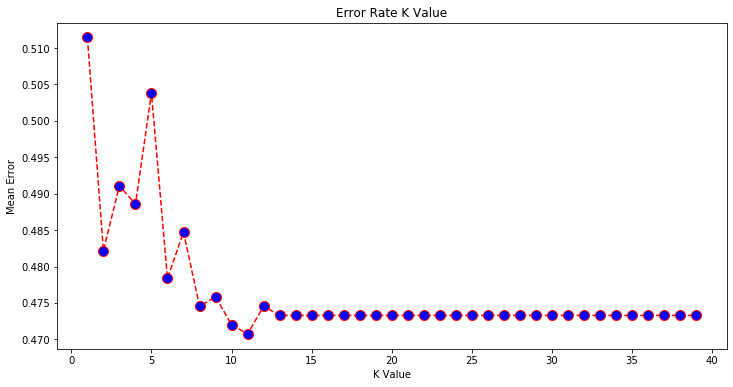

In [217]:
import matplotlib.pyplot as plt

error = []

for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')# из графика видно что этот алгоритм нам не потходит минимальная ошибка больше 0.4

In [38]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
pred_i = knn.predict(X_test)
reports(pred_i, y_test)

TrueNegative = 391
FalsePositive = 23
FalseNegative = 356
TruePositive = 16

              precision    recall  f1-score   support

         0.0       0.52      0.94      0.67       414
         1.0       0.41      0.04      0.08       372

    accuracy                           0.52       786
   macro avg       0.47      0.49      0.38       786
weighted avg       0.47      0.52      0.39       786



# SVC

In [146]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='poly')
svclassifier.fit(X_train, y_train)

In [147]:
y_pred = svclassifier.predict(X_test)
reports(y_pred, y_test)

TrueNegative = 371
FalsePositive = 43
FalseNegative = 337
TruePositive = 35

              precision    recall  f1-score   support

         0.0       0.52      0.90      0.66       414
         1.0       0.45      0.09      0.16       372

    accuracy                           0.52       786
   macro avg       0.49      0.50      0.41       786
weighted avg       0.49      0.52      0.42       786



In [150]:
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [151]:
y_pred = svclassifier.predict(X_test)
reports(y_pred, y_test)

TrueNegative = 257
FalsePositive = 157
FalseNegative = 239
TruePositive = 133

              precision    recall  f1-score   support

         0.0       0.52      0.62      0.56       414
         1.0       0.46      0.36      0.40       372

    accuracy                           0.50       786
   macro avg       0.49      0.49      0.48       786
weighted avg       0.49      0.50      0.49       786



Text(0, 0.5, 'Mean Error')

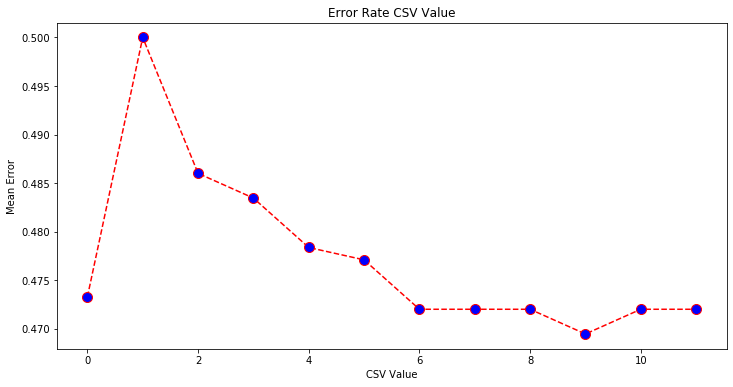

In [24]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
error = []
for i in range(12):
    X_train, X_test, y_train, y_test = v_train, v_test, values_train, values_test
    clf = SVC(gamma='scale', kernel = 'poly', degree = i)
    clf.fit(X_train, y_train)
    SVC(gamma='scale')
    y_pred = clf.predict(X_test)
    error.append(np.mean(y_pred != y_test))
plt.figure(figsize=(12, 6))
plt.plot(range(12), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate Poly Value')
plt.xlabel('Polynom Value')
plt.ylabel('Mean Error')

In [40]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = v_train, v_test, values_train, values_test
clf = SVC(gamma='scale', kernel = 'poly', degree = 2)
clf.fit(X_train, y_train)
SVC(gamma='scale')
y_pred = clf.predict(X_test)
reports(y_pred, y_test)

TrueNegative = 311
FalsePositive = 103
FalseNegative = 279
TruePositive = 93

              precision    recall  f1-score   support

         0.0       0.53      0.75      0.62       414
         1.0       0.47      0.25      0.33       372

    accuracy                           0.51       786
   macro avg       0.50      0.50      0.47       786
weighted avg       0.50      0.51      0.48       786



In [44]:
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0.

In [55]:
df_ss.head()

,example_id,label
0,24bf52cc84b75bce8ee9c0cdd0b5117f,False
1,708cc462eca0c274bcff304bbc4396f8,False
2,c5da1d371af9525d2fc2174311e3dae4,False
3,844f5f5be464a0600891ac6b8c1a1afd,False
4,97daba48c36db68f3e84ebcbf8952aa2,True


In [58]:
#'example_id': df_test['example_id'], 'label': y_pred.astype(bool)
index = df_test['example_id']
val = y_pred.astype(bool)
df = dataset = pd.DataFrame({'example_id': df_test['example_id'], 'Column2': val})
df

,example_id,Column2
0,24bf52cc84b75bce8ee9c0cdd0b5117f,False
1,708cc462eca0c274bcff304bbc4396f8,False
2,c5da1d371af9525d2fc2174311e3dae4,False
3,844f5f5be464a0600891ac6b8c1a1afd,False
4,97daba48c36db68f3e84ebcbf8952aa2,False
...,...,...
781,d88c14f3513eeac07d96bf2247e590da,False
782,d86ba8e778366f29d751212248a8b117,True
783,77d311fd2f0fe6e7120e92efc00a3dc1,False
784,d1e6b79eed2ed19f35c2bbc3bf3c7940,True


In [59]:
df_ss['example_id'] = df_test['example_id']
df_ss['label'] = val
df_ss.head()

,example_id,label
0,24bf52cc84b75bce8ee9c0cdd0b5117f,False
1,708cc462eca0c274bcff304bbc4396f8,False
2,c5da1d371af9525d2fc2174311e3dae4,False
3,844f5f5be464a0600891ac6b8c1a1afd,False
4,97daba48c36db68f3e84ebcbf8952aa2,False


In [60]:
df_ss.tail()

,example_id,label
781,d88c14f3513eeac07d96bf2247e590da,False
782,d86ba8e778366f29d751212248a8b117,True
783,77d311fd2f0fe6e7120e92efc00a3dc1,False
784,d1e6b79eed2ed19f35c2bbc3bf3c7940,True
785,39f1960e9fa6d6dee905f7380922d29d,False


In [63]:
df_ss.head(15)

,example_id,label
0,24bf52cc84b75bce8ee9c0cdd0b5117f,False
1,708cc462eca0c274bcff304bbc4396f8,False
2,c5da1d371af9525d2fc2174311e3dae4,False
3,844f5f5be464a0600891ac6b8c1a1afd,False
4,97daba48c36db68f3e84ebcbf8952aa2,False
5,5aa7363096040ffc17b20f595edda878,False
6,a096ea460d0c9f2af7211c8f2d1d7ee7,False
7,ff4a30ad03aa3b4485a542dd32919722,False
8,0841f6a99ed3dd2ba9b8cec3b0a1451c,False
9,6d368e9b25aebb7bfbda01c4eb7533f4,True


In [65]:
df_ss.to_csv(r'df_pract_galkin.csv', index = False)

Text(0, 0.5, 'Mean Error')

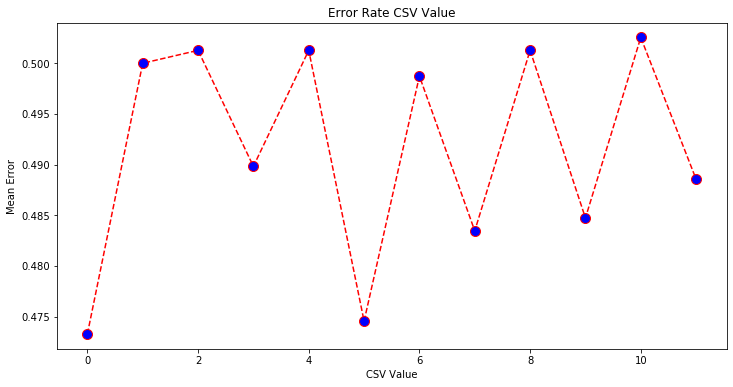

In [16]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
error = []
for i in range(12):
    X_train, X_test, y_train, y_test = v_train, v_test, values_train, values_test
    clf = SVC(gamma='scale', kernel = 'poly', degree = i, coef0 = -1)
    clf.fit(X_train, y_train)
    SVC(gamma='scale')
    y_pred = clf.predict(X_test)
    error.append(np.mean(y_pred != y_test))
plt.figure(figsize=(12, 6))
plt.plot(range(12), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate CSV Value')
plt.xlabel('CSV Value')
plt.ylabel('Mean Error')

In [17]:
X_train, X_test, y_train, y_test = v_train, v_test, values_train, values_test
clf = SVC(gamma='scale', kernel = 'sigmoid')
clf.fit(X_train, y_train)
SVC(gamma='scale')
y_pred = clf.predict(X_test)
reports(y_pred, y_test)

TrueNegative = 271
FalsePositive = 143
FalseNegative = 242
TruePositive = 130

              precision    recall  f1-score   support

         0.0       0.53      0.65      0.58       414
         1.0       0.48      0.35      0.40       372

    accuracy                           0.51       786
   macro avg       0.50      0.50      0.49       786
weighted avg       0.50      0.51      0.50       786



In [21]:
X_train, X_test, y_train, y_test = v_train, v_test, values_train, values_test
clf = SVC(gamma='auto', C = 2.0)
clf.fit(X_train, y_train)
SVC(gamma='scale')
y_pred = clf.predict(X_test)
reports(y_pred, y_test)

TrueNegative = 411
FalsePositive = 3
FalseNegative = 370
TruePositive = 2

              precision    recall  f1-score   support

         0.0       0.53      0.99      0.69       414
         1.0       0.40      0.01      0.01       372

    accuracy                           0.53       786
   macro avg       0.46      0.50      0.35       786
weighted avg       0.47      0.53      0.37       786



# LogisticRegression

In [156]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression () 
lr.fit (X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [157]:
y_pred = lr.predict(X_test)

In [159]:
reports(y_pred, y_test)

TrueNegative = 273
FalsePositive = 141
FalseNegative = 246
TruePositive = 126

              precision    recall  f1-score   support

         0.0       0.53      0.66      0.59       414
         1.0       0.47      0.34      0.39       372

    accuracy                           0.51       786
   macro avg       0.50      0.50      0.49       786
weighted avg       0.50      0.51      0.49       786



# LDA

In [162]:

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA()
x_train = lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
reports(y_pred, y_test)

TrueNegative = 234
FalsePositive = 180
FalseNegative = 216
TruePositive = 156

              precision    recall  f1-score   support

         0.0       0.52      0.57      0.54       414
         1.0       0.46      0.42      0.44       372

    accuracy                           0.50       786
   macro avg       0.49      0.49      0.49       786
weighted avg       0.49      0.50      0.49       786



# Next try

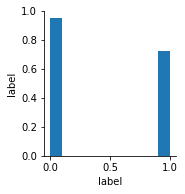

In [203]:
import seaborn as sns
df_n = pd.DataFrame({"label": np.array([value for value in df_all['label']]).astype('int'), "text":np.array(create_vec(l) for l in lst_all)})
sns.pairplot(df_n)

### Если нельзя определить по словам к какой категории относится фраза нужно искать другие кореляции

In [226]:
#lst_train
#lst_test
#lst_all
P = 481 / (708 + 481)
print(P)

0.40454163162321277


In [172]:
lst_true = []
lst_false = []
for i in range(1189):
    if df_train.label[i] != 0:
        lst_true.append(lst_train[i])
    else:
        lst_false.append(lst_train[i])

In [173]:
print(len(lst_true))
print(len(lst_false))

481
708


In [174]:
vec_true = np.zeros(len(cleaned_vocab))
for v in lst_true:
    vec_true = vec_true + creat_vec(v)
vec_false = np.zeros(len(cleaned_vocab))
for v in lst_false:
    vec_false = vec_false + creat_vec(v)

In [223]:
vec_true.sum(axis=0)/481# В среднем на одно слово больше

6.407484407484407

In [224]:
vec_false.sum(axis=0)/708

5.453389830508475

In [175]:
weight = []
for v1, v2 in zip(vec_true, vec_false):
    if v1!=0 and v2!=0:
        weight.append(v1/v2)
    elif v1!=0 and v2==0:
        weight.append(v1)
    elif v1==0 and v2!=0:
        weight.append(1/v2)
    else:
        weight.append(1)#нулевой элемент кольца
weight = np.array(weight)
print(len(weight))

818


In [176]:
v_t = v_test.copy()
len(v_test)

786

In [188]:
v_t

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [192]:
ans = np.array([t*weight for t in v_t])
print(len(ans))
ans.shape

786


(786, 818)

In [193]:
vec_sum = ans.sum(axis = 1)
vec_sum.shape

(786,)

In [194]:
tp = 0
tn = 0
fp = 0
fn = 0
for my_ans, true_ans in zip(vec_sum, values_test):
    if my_ans >= 1 and true_ans == 1:
        tp += 1
    elif my_ans < 1 and true_ans == 0:
        tn += 1
    if my_ans >= 1 and true_ans == 0:
        fp += 1
    if my_ans < 1 and true_ans == 1:
        fn += 1
print('TrueNegative = {}\nFalsePositive = {}\nFalseNegative = {}\nTruePositive = {}\n'.format(tn, fp, fn, tp))

TrueNegative = 12
FalsePositive = 402
FalseNegative = 18
TruePositive = 354



In [119]:
weight

array([  -8.,  -23.,  -14.,  -74.,   -5., -168.,   -4.,    1.,    1.,
          2.,  -18.,  -16.,   -6.,    3.,    0.,   -1.,    1.,    6.,
         -8.,    3.,   -3.,   82.,   -8.,  -13.,   -2.,   27.,   -7.,
          4.,    3.,  -51.,    2.,  -15.,   -2.,   15.,  -32.,    2.,
         -3.,    2.,   -2.,   -9.,    0.,    1.,   -2.,    5.,   12.,
         -3.,  -10.,   -2.,  -20.,  -17.,   -2.,   -2.,    8.,    1.,
          1.,    3.,   -6.,   -3.,   -7.,   -5.,   -2.,   -4.,   -7.,
         -3.,   -4.,    0.,    4.,   -1.,   -1.,    3.,   -5.,    5.,
          7.,    8.,   24.,   -3.,    1.,    1.,    1.,    6.,    4.,
          5.,   -2.,   -2.,    5.,    2.,   18.,    2.,    5.,    6.,
          6.,   -2.,   -1.,   -8.,   -1.,  -15.,  -12.,  -14.,    3.,
          2.,   -8.,   -4.,   -2.,   -4.,  -11.,   -8.,   -6.,    1.,
         10.,   -2.,   -6.,    0.,   -5.,   -7.,   -1.,   -1.,    1.,
          2.,   -1.,   -1.,    3.,    3.,   -3.,  -13.,   -1.,    1.,
          0.,    1.,